#### Student Name: Zheng Hanming
#### Student ID: 21225621

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline


#### Helpers

In [2]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)


# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1
def evaluate_model(X_test, y_test, model, mean_fpr):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]

    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)

    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)

    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(
        y_test, _predicted_values, labels=[1])

    # compute fpr and tpr values for various thresholds
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)

    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])

    # compute the area under the curve
    _auc = auc(_fpr, _tpr)

    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc


def plot_metrics(metrics):
    index = ['accuracy', 'precision', 'recall', 'F1-score']
    df_metrics = pd.DataFrame(metrics, index=index)
    df_metrics.plot.bar(rot=0)
    plt.legend(loc="lower right")
    plt.show()

def plot_roc(roc_metrics, mean_fpr):
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
    # plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
    # plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
    for metric in roc_metrics.items():
        plt.plot(mean_fpr, metric[1][0][0,:], lw=2, label=f'{metric[0]} (AUC = %0.2f)' % (metric[1][1]), alpha=0.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves for multiple classifiers')
    plt.legend(loc="lower right")
    plt.show()

def train_model(classifier, param_grid, X_train, y_train):
    classifier_name = 'classifier'
    # Training Pipeline
    updated_params = {classifier_name + '__' + str(key): value for key, value in param_grid.items()}

    preprocess_train_pipeline = Pipeline(steps=[('preprocess', preprocess), (classifier_name, classifier)])
    search = GridSearchCV(preprocess_train_pipeline, updated_params, n_jobs=-1, cv=20, refit=True)
    # The parameter `refit = True` makes the GridSearchCV train an classifier on the ** whole training set ** with the best parameters found.
    # This best model can then be accessed via the `.best_estimator_` attribute of the GridSearchCV.

    search.fit(X_train, y_train)

    best = {
        'params': {key.replace(classifier_name + '__', ''): value for key, value in search.best_params_.items()},
        'model': search.best_estimator_,
        'score': search.best_score_
    }

    print("--------------------------------------------------------------------------------------")
    print(f"Best CV score({classifier.__class__.__name__}): {round(best.get('score'), 3)}")
    print(f"Best parameters({classifier.__class__.__name__}): {best.get('params')}")

    return best


#### Import & Observe Data

In [3]:
# https://archive.ics.uci.edu/ml/datasets/seeds
df = pd.read_csv("./seeds.csv")
df.head()


area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1

In [4]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

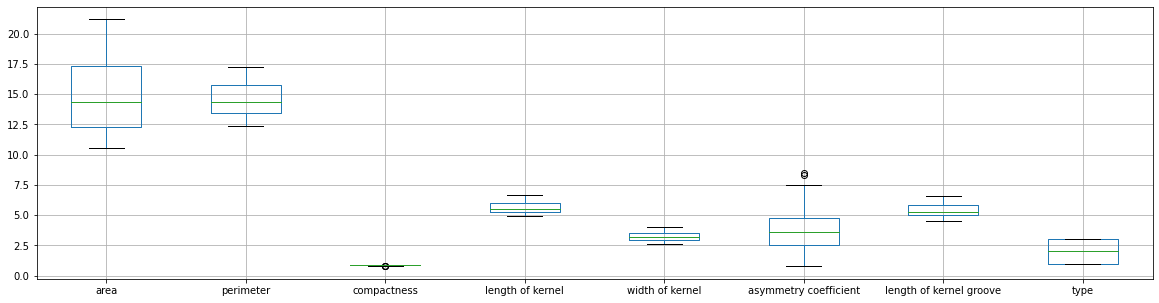

In [5]:
df.boxplot(figsize=(20, 5))
plt.show()

In [6]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

#### Initialization

In [7]:
target_name = 'type'
all_features_names = [col_name for col_name in df if col_name != target_name]

mean_fpr = np.linspace(start=0, stop=1, num=100)
preprocess = make_pipeline(AddColumnNames(columns=all_features_names), StandardScaler())


#### Task 2

- ✔️ You will need to formulate a binary classification problem and transform the type column accordingly. 

In [8]:
df['type'] = df['type'].replace({1: 0, 2: 1, 3: 1})


- ✔️ Replicate the classifier training and evaluation demonstrated in the example notebook Lab 4 - Comparison of Binary Classifiers.ipynb but with the dataset seeds.csv. 


In [9]:
y = df[target_name]
X = df[all_features_names]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)
# The parameter `stratify=y` ensures both classes are represented in the same proportion in both the training and the test sets.
# Note that after the split into a training and test sets, X_train and X_test are numpy arrays and no longer have column names. 
# That's why we needed the class above to put the names of columns back in the preprocessing pipeline.

In [10]:
print('Training SVM & Random Forest Models')
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly']
}
svm_best = train_model(svm.SVC(probability=True), svm_param_grid, X_train, y_train)

rf_param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [2, 4, 6, 8]
}
rf_best = train_model(RandomForestClassifier(), rf_param_grid, X_train, y_train)


Training SVM & Random Forest Models
--------------------------------------------------------------------------------------
Best CV score(SVC): 0.965
Best parameters(SVC): {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
--------------------------------------------------------------------------------------
Best CV score(RandomForestClassifier): 0.942
Best parameters(RandomForestClassifier): {'max_depth': 8, 'n_estimators': 20}


Evaluate Chosen/Best SVM & Random Forest Models


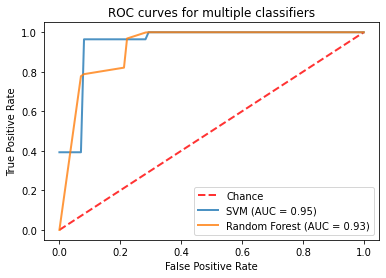

In [11]:
print('Evaluate Chosen/Best SVM & Random Forest Models')
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, svm_best.get('model'), mean_fpr)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, rf_best.get('model'), mean_fpr)
svm_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
rf_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])

metrics = { 'SVM': svm_metrics, 'Random Forest': rf_metrics }
plot_metrics(metrics)

metrics_roc = {'SVM': (SVM_tpr, SVM_auc), 'Random Forest': (RF_tpr, RF_auc)}
plot_roc(metrics_roc, mean_fpr)


- ✔️ Summarise your conclusions (max 200 words in a markdown cell).
  - We need to make this multi class classification a binary classification problem. To do that, we randomly choose any two types and combine into one. 
    - type 1 => class 0
    - type 2 & 3 => class 1
  - Cost for misclassificaton varies between different use cases. For medical field, it is more costly to have false negative than false positively. For our case, I believe the cost of misclassifying wheat kernels is not as significant as the medical use cases. So the cost of misclassification is low.
  - The results for SVM and RF are very close most of the time, with SVM edge out more times than RF. And therefore, SVM is chosen as the better model to use.
    - Accuracy, precision, recall and f-score are usually higher for SVM.
    - Our case study does not have significant cost of miss-classification for any class. Therefore, we do not need to manually adjust the tolerance. And according to the AUC, we can also see that SVM is better than RF.
    - Note:
      - accuracy: total correct classifications / total samples => higher = better
      - recall: true positive / actual positives => higher = better
      - precision: true positive / predicted positives => higher = better
      - f1-score: 2 * ((precision*recall)/(precision+recall)) considers both precision and recall => higher = better (1 means perfect)

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/ (for self reference)

#### Task 3

- ✔️ Train a third classifier (e.g., MLPClassifier, Naive Bayes, kNN) with seeds.csv add compare it to both SVM and Random Forest. 
- ✔️ Summarise your experience with exploring the parameters (max 150 words in a markdown cell).
  - Parameters:
    - n_neighbors: number of neighbors
    - weights: weight function used in prediction
      - uniform: all points in each neighborhood are weighted equally
      - distance: neighbors nearer to the query point will have greater influence than neighbors that are far away
    - algorithm: algorithm to compute the nearest neighbors
  - I did not try a high volume of parameters, in order to improve the speed of computation. An alternative will be to use BayesSearchCV which performs better on more parameters. It optimize the optimization by not running through each combination of the params.
  - Comparison:
    - With the parameters I have tested, KNN does not perform as well as SVM but slightly better than RF based on accuracy, recall & F-score.
    - AUC also suggests that SVM out-performs the rest.

In [12]:
print('Training KNN Model')
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
knn_best = train_model(KNeighborsClassifier(n_jobs=-1), knn_param_grid, X_train, y_train)


Training KNN Model
--------------------------------------------------------------------------------------
Best CV score(KNeighborsClassifier): 0.931
Best parameters(KNeighborsClassifier): {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'}


Evaluate Chosen/Best SVM, Random Forest & KNN Models


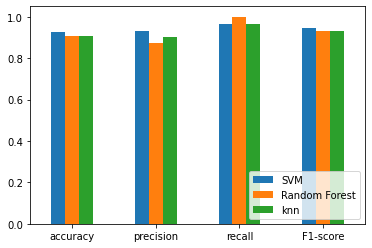

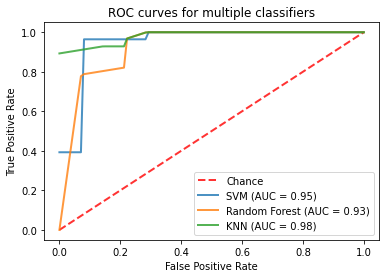

In [13]:
print('Evaluate Chosen/Best SVM, Random Forest & KNN Models')
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, knn_best.get('model'), mean_fpr)
knn_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])

metrics['knn'] = knn_metrics
plot_metrics(metrics)

metrics_roc['KNN'] = (KNN_tpr, KNN_auc)
plot_roc(metrics_roc, mean_fpr)


#### Final Model Export

In [14]:
best_pipeline = make_pipeline(preprocess, svm.SVC(**svm_best.get('params')))
final_model = best_pipeline.fit(X, y)
pickle.dump(final_model, open('final_model.sav', 'wb'))
